# CS 39AA - Project Part 3

# Further fine tuning the dataset from the baseline model with BERT. A continuation of [Part 2](https://github.com/hunpham/cs39aa_project/blob/main/project_part2.ipynb). 

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/hunpham/cs39aa_project/blob/main/project_part3.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hunpham/cs39aa_project/blob/main/project_part3.ipynb)

In [10]:
# import all of the python modules/packages you'll need here
import transformers
from transformers import BertTokenizerFast, TFBertModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils import data
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji
import nltk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score


from imblearn.over_sampling import RandomOverSampler
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict, load_metric

seed=42

# An overview of the dataset

In [11]:
df_train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding="ISO-8859-1")
print(df_train.shape)
print(df_train.columns)
print(df_train.head())
print(df_test.head())

(41157, 6)
Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1 

# Drop unnessessary collumns and duplicates

In [12]:
df_train.drop(columns = ['UserName','ScreenName','Location','TweetAt'], inplace=True)
df_train.drop_duplicates(subset='OriginalTweet', inplace=True)
df_train = df_train.reset_index(drop=True)
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Total sentiments and word per tweet satistics

In [13]:
df_train["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

1 64


<AxesSubplot:xlabel='Word lengths', ylabel='Count'>

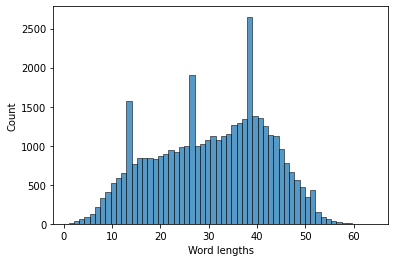

In [14]:
df_train['Word lengths'] = df_train['OriginalTweet'].apply(lambda t: len(t.split()))
min_len_word, max_len_word = df_train['Word lengths'].min(), df_train['Word lengths'].max()
print(min_len_word, max_len_word)
sns.histplot(df_train['Word lengths'])

In [15]:
df_train.describe()

,Word lengths
count,41157.000000
mean,30.500304
std,11.591172
min,1.000000
25%,21.000000
50%,32.000000
75%,40.000000
max,64.000000


# Word Cloud

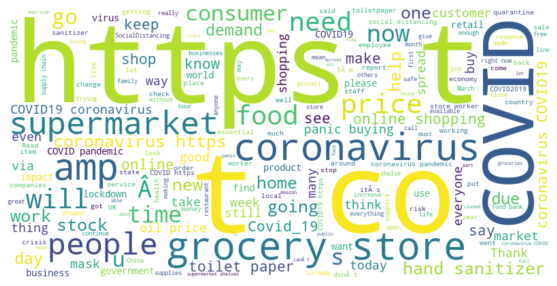

In [16]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.OriginalTweet))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Cleanup the training dataset by removing whitespaces, numbers, unwanted errors, reference from: https://www.kaggle.com/code/zahraarabi/sentiment-analysis-with-bert-model-pytorch#Data-Preprocessing

In [17]:
def cleanup(tweet):
    # remove links
    tweet = "".join(re.sub("(\w+:\/\/\S+)"," ", tweet))
    
    # remove hashtags
    tweet = "".join(re.sub("(#[A-Za-z0-9_]+)"," ", tweet))
    
    # remove user mention
    tweet = "".join(re.sub("(@[A-Za-z0-9_]+)"," ", tweet))
    
    # remove none alphanumeric and aposthrope
    tweet = "".join(re.sub("([^0-9A-Za-z \t'])"," ", tweet))
    
    # remove extra whitespace
    tweet = " ".join(tweet.split())
    
    # remove emoji unicode 
    tweet = "".join(c for c in tweet if c not in emoji.EMOJI_DATA) #Remove Emojis
    
    # remove leading and trailing space
    tweet = tweet.strip()
    return tweet

In [18]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: cleanup(x))
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: cleanup(x))
print(df_train.head())
print(df_test.head())

                                       OriginalTweet           Sentiment  \
0                                            and and             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia Woolworths to give elder...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me ready to go at supermarket during the outbr...  Extremely Negative   

   Word lengths  
0             8  
1            38  
2            14  
3            42  
4            40  
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  

# Get tweets text length

In [19]:
text_len = []
for text in df_train.OriginalTweet:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df_train['text_len'] = text_len
text_len_test = []
for text in df_test.OriginalTweet:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)
df_test['text_len'] = text_len_test

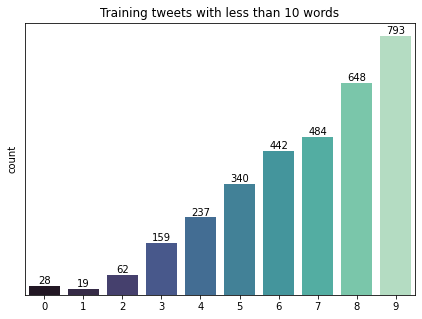

In [20]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

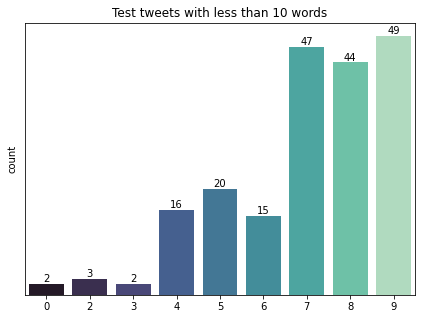

In [21]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Removing tweets that is less than 5 words

In [22]:
df_train = df_train[df_train['OriginalTweet'].apply(lambda x: len(x.split()) > 5)]
df_test = df_test[df_test['OriginalTweet'].apply(lambda x: len(x.split()) > 5)]
print(df_train.head())
print(df_test.head())

                                       OriginalTweet           Sentiment  \
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia Woolworths to give elder...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me ready to go at supermarket during the outbr...  Extremely Negative   
5  As news of the region s first confirmed COVID ...            Positive   

   Word lengths  text_len  
1            38        38  
2            14        14  
3            42        34  
4            40        33  
5            36        36  
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

              

# Map Sentiments to numbers and balace them out

In [23]:
df_train['Sentiment'].value_counts()

Positive              11243
Negative               9793
Neutral                7208
Extremely Positive     6608
Extremely Negative     5460
Name: Sentiment, dtype: int64

In [24]:
df_train['Sentiment'] = df_train['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [25]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

# From https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [26]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['OriginalTweet']).reshape(-1, 1), np.array(df_train['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['OriginalTweet', 'Sentiment']);
train_os['Sentiment'].value_counts()

2    17851
0    17851
1    17851
Name: Sentiment, dtype: int64

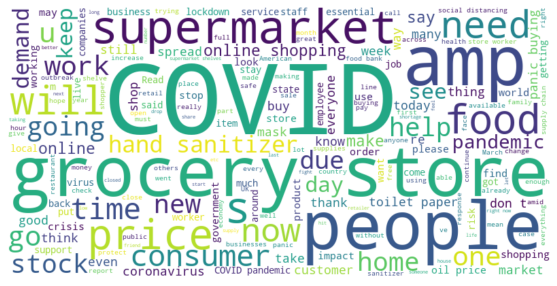

In [27]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.OriginalTweet))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Split Data to 10% Test & 90% Training

In [28]:
X = train_os['OriginalTweet'].values
y = train_os['Sentiment'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_test = df_test['OriginalTweet'].values
y_test = df_test['Sentiment'].values

print(f"Train Count: {X_train.shape[0]}\nValidation Count: {X_valid.shape[0]}\nTest Count: {X_test.shape[0]}" )

Train Count: 48197
Validation Count: 5356
Test Count: 3755


# Create a copy of Sentiments

In [29]:
y_train_2 = y_train.copy()
y_valid_2 = y_valid.copy()
y_test_2 = y_test.copy()

# One Hot Encode

In [30]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(48197, 3)
(5356, 3)
(3755, 3)


In [31]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [32]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Baseline Model using Multinomial Naive Bayes

In [33]:
nb_clf = MultinomialNB()

In [34]:
nb_clf = nb_clf.fit(X_train_tf, y_train_2)

In [35]:
nb_pred = nb_clf.predict(X_test_tf)

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.73      0.76      0.74      1630
     Neutral       0.60      0.50      0.55       587
    Positive       0.73      0.74      0.74      1538

    accuracy                           0.71      3755
   macro avg       0.69      0.67      0.68      3755
weighted avg       0.71      0.71      0.71      3755

accuracy (on X_train): 0.7124


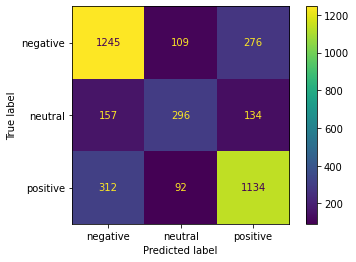

In [36]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_2, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_2, nb_pred), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_test_2, nb_pred):.4f}")

# Deep Learning Bert Model

In [37]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [38]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [39]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [40]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
def create_model(bert_model, max_len=MAX_LEN):
    
    # parameter
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    dropout = tf.keras.layers.Dropout(0.2)(embeddings)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [42]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 768)          0           tf_bert_model[0][1]          

In [43]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

2022-12-10 05:29:12.600130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
1507/1507 [==============================] - 756s 491ms/step - loss: 0.5743 - categorical_accuracy: 0.7635 - val_loss: 0.3266 - val_categorical_accuracy: 0.8792
Epoch 2/4
1507/1507 [==============================] - 737s 489ms/step - loss: 0.2664 - categorical_accuracy: 0.9049 - val_loss: 0.2054 - val_categorical_accuracy: 0.9277
Epoch 3/4
1507/1507 [==============================] - 737s 489ms/step - loss: 0.1728 - categorical_accuracy: 0.9374 - val_loss: 0.1857 - val_categorical_accuracy: 0.9363
Epoch 4/4
1507/1507 [==============================] - 736s 489ms/step - loss: 0.1182 - categorical_accuracy: 0.9583 - val_loss: 0.1668 - val_categorical_accuracy: 0.9455


In [44]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [45]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

accuracy (on X_train): 0.9116


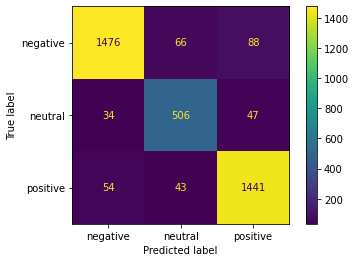

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1)), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_test.argmax(1), y_pred_bert.argmax(1)):.4f}")

In [47]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.94      0.91      0.92      1630
     Neutral       0.82      0.86      0.84       587
    Positive       0.91      0.94      0.93      1538

   micro avg       0.91      0.91      0.91      3755
   macro avg       0.89      0.90      0.90      3755
weighted avg       0.91      0.91      0.91      3755
 samples avg       0.91      0.91      0.91      3755



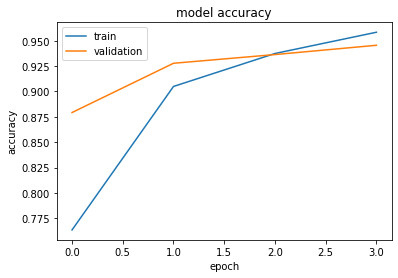

In [48]:
plt.plot(history_bert.history['categorical_accuracy'])
plt.plot(history_bert.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

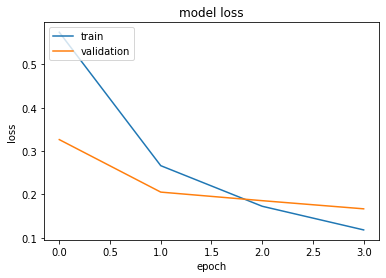

In [49]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()